In [289]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense,Dropout,Activation
from keras.optimizers import Adam
from keras.utils import np_utils
import math
import time
import matplotlib.pyplot as plt

In [290]:
# df_all = pd.read_csv('../rnn_data/all/2013_2018_price.csv',encoding='utf-8')
df_all = pd.read_csv('2012_2018_all.csv',encoding='utf-8')
df_c = df_all.groupby('證券代號').get_group('2330')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5,6,7,8,9,10,25,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [291]:
df_c.columns.values

array(['Unnamed: 0', '三大法人買賣超股數', '外資自營商買賣超股數', '外資自營商買進股數', '外資自營商賣出股數',
       '外資買賣超股數', '外資買進股數', '外資賣出股數', '外陸資買賣超股數(不含外資自營商)',
       '外陸資買進股數(不含外資自營商)', '外陸資賣出股數(不含外資自營商)', '成交筆數', '成交股數', '成交金額',
       '投信買賣超股數', '投信買進股數', '投信賣出股數', '收盤價', '日期', '最低價', '最後揭示買價',
       '最後揭示買量', '最後揭示賣價', '最後揭示賣量', '最高價', '本益比', '漲跌(+/-)', '漲跌價差',
       '自營商買賣超股數', '自營商買賣超股數(自行買賣)', '自營商買賣超股數(避險)', '自營商買進股數',
       '自營商買進股數(自行買賣)', '自營商買進股數(避險)', '自營商賣出股數', '自營商賣出股數(自行買賣)',
       '自營商賣出股數(避險)', '證券代號', '證券名稱', '開盤價'], dtype=object)

In [292]:
# del df_c['三大法人買賣超股數']
del df_c['外資自營商買賣超股數']
del df_c['外資自營商買進股數']
del df_c['外資自營商賣出股數']
del df_c['外資買賣超股數']
del df_c['外資買進股數']
del df_c['外資賣出股數']
del df_c['外陸資買賣超股數(不含外資自營商)']
del df_c['外陸資買進股數(不含外資自營商)']
del df_c['外陸資賣出股數(不含外資自營商)']
del df_c['投信買賣超股數']
del df_c['投信買進股數']
del df_c['投信賣出股數']
del df_c['最後揭示買價']
del df_c['自營商買賣超股數']
del df_c['自營商買賣超股數(自行買賣)']
del df_c['自營商買賣超股數(避險)']
del df_c['自營商買進股數']
del df_c['最後揭示買量']
del df_c['最後揭示賣價']
del df_c['最後揭示賣量']
del df_c['自營商賣出股數']
del df_c['自營商買進股數(避險)']
del df_c['自營商賣出股數(自行買賣)']
del df_c['自營商賣出股數(避險)']
del df_c['自營商買進股數(自行買賣)']
# del df_c['自營商賣出股數(自行買賣)']
# del df_c['自營商賣出股數(避險)']

In [265]:
def batch_data(df_c,time_steps,seperate_rate):
    del df_c['Unnamed: 0']
    del df_c['證券代號']
    del df_c['本益比']
    del df_c['成交金額']
    del df_c['證券名稱']
    empty_li = df_c[df_c['漲跌(+/-)']=='X'].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['漲跌(+/-)']==' '].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['收盤價']=='X'].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['收盤價']==' '].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    df_c['成交筆數']=df_c['成交筆數'].str.replace(',','')
    df_c['成交股數']=df_c['成交股數'].str.replace(',','')
    df_c['三大法人買賣超股數']=df_c['三大法人買賣超股數'].str.replace(',','')
    df_c.三大法人買賣超股數 = df_c.三大法人買賣超股數.astype(float)
    df_c.成交筆數 = df_c.成交筆數.astype(float)
    df_c.成交股數 = df_c.成交股數.astype(float)
    df_c.收盤價 = df_c.收盤價.astype(float)
    df_c.最低價 = df_c.最低價.astype(float)
    df_c.最高價 = df_c.最高價.astype(float)
    df_c.開盤價 = df_c.開盤價.astype(float)
    df_c.漲跌價差 = df_c.漲跌價差.astype(float)
    df_c['return'] = np.where(df_c['漲跌(+/-)'] !='+',df_c['漲跌價差']*-1, df_c['漲跌價差'])
    df_c['return']=df_c['return'].shift(-1)
#     df_c['label'] = (df_c['return']+df_c['return'].shift(-7)+df_c['return'].shift(-6)+df_c['return'].shift(-5)+df_c['return'].shift(-4)+df_c['return'].shift(-3)+df_c['return'].shift(-2)+df_c['return'].shift(-1))/df_c['收盤價']*100
#     df_c['label'] = (df_c['return']+df_c['return'].shift(-2)+df_c['return'].shift(-1))/df_c['收盤價']*100
    df_c['label'] = (df_c['收盤價'].shift(-5)-df_c['收盤價'])/df_c['收盤價']*10
    df_c1=df_c
    
#     min_max_scaler = MinMaxScaler(feature_range=(-1,1))
#     df_c['label']=min_max_scaler.fit_transform(df_c['label'].fillna(0).reshape(-1,1))
#     df_c['label']=min_max_scaler.fit_transform(df_c['收盤價'].shift(-2).fillna(0).reshape(-1,1))
    del df_c['漲跌(+/-)']
    del df_c['漲跌價差']
    del df_c['return']
    d= df_c['日期']
    del df_c['日期']
    
    
    
    #remove feature
    del df_c['開盤價']
    
    
    
    print(df_c.columns.values)
    print(df_c.shape)
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    for i in range(len(df_c.columns)-1):
        df_c[df_c.columns[i]] =min_max_scaler.fit_transform(np.array(df_c[df_c.columns[i]]).reshape(-1,1))
    Y_batch = df_c['label']
    del df_c['label']
    X_batch = df_c
    X_batch = np.array(X_batch)
    Y_batch = np.array(Y_batch)
    
#     Y_batch = np_utils.to_categorical(Y_batch)
    n = len(X_batch)
    drop_n = n%time_steps
    X_batch_t=[]
    Y_batch_t=[]
    for i in range(0,len(X_batch)-time_steps):
        X_batch_t.append(X_batch[i:i+time_steps])
        Y_batch_t.append(Y_batch[i+time_steps])
    train_size = math.ceil(len(X_batch_t)*seperate_rate)
    X_batch_t_train =  X_batch_t[:train_size]
    Y_batch_t_train = Y_batch_t[:train_size]
    X_batch_t_test = X_batch_t[train_size:]
    Y_batch_t_test = Y_batch_t[train_size:]
    X_batch_t_train=np.array(X_batch_t_train)
    Y_batch_t_train=np.array(Y_batch_t_train)
    X_batch_t_test=np.array(X_batch_t_test)
    Y_batch_t_test=np.array(Y_batch_t_test)
    return X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,df_c

In [266]:
def g_b(X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,BATCH_SIZE):
    X_batch_t_train_b=[]
    Y_batch_t_train_b=[]
    dn= X_batch_t_train.shape[0]%BATCH_SIZE
    print(dn)
    for i in range(dn,X_batch_t_train.shape[0],BATCH_SIZE):
        X_batch_t_train_b.append(X_batch_t_train[i:i+BATCH_SIZE])
        Y_batch_t_train_b.append(Y_batch_t_train[i:i+BATCH_SIZE])
    X_batch_t_train_b=np.array(X_batch_t_train_b)
    Y_batch_t_train_b=np.array(Y_batch_t_train_b)
    X_batch_t_test_b=[]
    Y_batch_t_test_b=[]
    for i in range(0,X_batch_t_test.shape[0],BATCH_SIZE):
        X_batch_t_test_b.append(X_batch_t_test[i:i+BATCH_SIZE])
        Y_batch_t_test_b.append(Y_batch_t_test[i:i+BATCH_SIZE])
    X_batch_t_test_b=np.array(X_batch_t_test_b)
    Y_batch_t_test_b=np.array(Y_batch_t_test_b) 
    return X_batch_t_train_b,Y_batch_t_train_b,X_batch_t_test_b,Y_batch_t_test_b

In [267]:
time_steps=60
seperate_rate=0.7
TIME_STEPS = time_steps
INPUT_SIZE = 6
CELL_SIZE = 3
OUTPUT_SIZE=16
LR = 0.0001

In [268]:
X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,df_c=batch_data(df_c,time_steps,seperate_rate)

['三大法人買賣超股數' '成交筆數' '成交股數' '收盤價' '最低價' '最高價' 'label']
(1271, 7)


In [269]:
print(X_batch_t_train.shape,X_batch_t_test.shape)

(848, 60, 6) (363, 60, 6)


In [270]:
BATCH_SIZE=121

#train
X_batch_t_train=X_batch_t_train[1:]
Y_batch_t_train=Y_batch_t_train[1:]
#test
X_batch_t_test=X_batch_t_test[:]
Y_batch_t_test=Y_batch_t_test[:]


In [271]:
X_batch_t_train_b,Y_batch_t_train_b,X_batch_t_test_b,Y_batch_t_test_b=g_b( X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,BATCH_SIZE)

0


In [272]:
X_batch_t_test_b.shape

(3, 121, 60, 6)

In [273]:
INPUT_SIZE = 6
CELL_SIZE = 30
OUTPUT_SIZE=16
LR = 0.0001

In [274]:
model =Sequential()
model.add(LSTM(
    batch_input_shape=(BATCH_SIZE,TIME_STEPS, INPUT_SIZE),
    output_dim=128,
    return_sequences=False,
    stateful=True,
))
# model.add(Dense(batch_input_shape=BATCH_SIZE*TIME_STEPS,activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='tanh'))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1))
adam = Adam(LR)
model.compile(optimizer=adam,
              loss='mse')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(121, 60, ..., return_sequences=False, stateful=True, units=128)`
  


In [275]:
X_batch_t_train_b[0].shape

(121, 60, 6)

In [276]:
epoch = 2001
cl = []
start_time = time.time()
cl_chart=[]
for epoch in range(epoch):
    for i in range(X_batch_t_train_b.shape[0]):
#         print(X.shape)
        X = X_batch_t_train_b[i].reshape(BATCH_SIZE,TIME_STEPS,INPUT_SIZE)
        Y = Y_batch_t_train_b[i].reshape(BATCH_SIZE,1)
        cost = model.train_on_batch(X,Y)
#         pred = model.predict_class(X,Y)
#         pred = model.predict(X, 1)
#         cl_chart.append(cost)
#         if cost<20:
#             cl.append(cost)
        cl.append(cost)
    if epoch % 100  == 0:
        print('cl',np.average(cl))
        
        print('train cost: ', cost,'epoch: ',epoch)
#         print('class',pred)
        cl=[]
t=(start_time-time.time())*-1
print('耗時:'+str(t)+'s')

cl 0.23083894
train cost:  0.12975346 epoch:  0
cl 0.10011793
train cost:  0.08274117 epoch:  100
cl 0.096121006
train cost:  0.08638385 epoch:  200
cl 0.09423004
train cost:  0.08236563 epoch:  300
cl 0.09131989
train cost:  0.08054859 epoch:  400
cl 0.088199876
train cost:  0.08647076 epoch:  500
cl 0.080236204
train cost:  0.076220915 epoch:  600
cl 0.07017378
train cost:  0.07273835 epoch:  700
cl 0.06462924
train cost:  0.0715997 epoch:  800
cl 0.0604227
train cost:  0.054194584 epoch:  900
cl 0.052016225
train cost:  0.04629784 epoch:  1000
cl 0.0470699
train cost:  0.058422234 epoch:  1100
cl 0.04386965
train cost:  0.03776918 epoch:  1200
cl 0.040458072
train cost:  0.037602257 epoch:  1300
cl 0.036247034
train cost:  0.03128776 epoch:  1400
cl 0.033228584
train cost:  0.028094195 epoch:  1500
cl 0.030035788
train cost:  0.028520063 epoch:  1600
cl 0.029080292
train cost:  0.027997157 epoch:  1700
cl 0.027864516
train cost:  0.02497738 epoch:  1800
cl 0.02606971
train cost:  0.

In [277]:
yhat=[]
for i in range(len(X_batch_t_test_b)):
    yhat.append(model.predict_on_batch((X_batch_t_test_b[i])))

In [278]:
shift_days=5

In [279]:
for i in range(-1,-1*(shift_days+1),-1):
    Y_batch_t_test[i]=Y_batch_t_test[-1*(shift_days+1)]

In [280]:
np.average((yhat-Y_batch_t_test)**2)

0.09186711269056294

In [281]:
# cost = model.train_on_batch(X,Y)

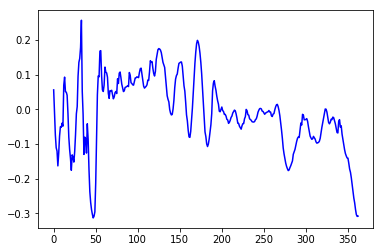

In [282]:
yhat=np.array(yhat).flatten()
plt.plot(yhat,color='blue')
plt.show()

In [283]:
np.average(Y_batch_t_test)

0.05076248029354953

In [284]:
np.average(yhat)

-0.011195272

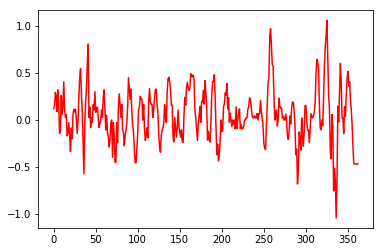

In [285]:
plt.plot(Y_batch_t_test,color='red')
plt.show()

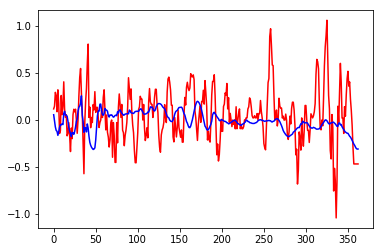

In [286]:
plt.plot(Y_batch_t_test,color='red')
plt.plot(yhat,color='blue')
plt.show()

,三大法人買賣超股數,成交筆數,成交股數,收盤價,最低價,最高價
283,0.094163,-0.278211,-0.430494,-0.855799,-0.866171,-0.852510
1139,0.092211,-0.607713,-0.686687,-0.850575,-0.854488,-0.851464
1996,-0.107258,-0.614603,-0.561953,-0.864159,-0.867233,-0.861925
2853,-0.229478,-0.469135,-0.434649,-0.885057,-0.885289,-0.877615
3710,-0.239216,-0.446818,-0.460624,-0.897597,-0.891662,-0.882845
4567,-0.119141,-0.495925,-0.517712,-0.895507,-0.901221,-0.891213
5425,0.034660,-0.664378,-0.674698,-0.888192,-0.892724,-0.885983
6284,-0.057491,-0.548991,-0.613044,-0.886102,-0.890600,-0.885983
7143,0.030769,-0.856537,-0.856380,-0.887147,-0.887414,-0.888075
8002,0.027407,-0.718473,-0.649092,-0.886102,-0.894849,-0.885983


In [287]:
df_c_p = df_c[-(yhat):]
df_c_p['s']=yhat
print(df_c_p['s'].describe())
plt.hist(df_c_p['s'])
plt.show()
plt.plot(df_c_p['s'])
plt.show()

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [[-5.60403503e-02  1.09050339e-02  7.36508742e-02  1.10774979e-01
  1.20351538e-01  1.63164034e-01  1.26530856e-01  7.72809833e-02
  5.02070226e-02  5.20805530e-02  3.99975665e-02  4.86463197e-02
 -6.93978295e-02 -9.28409174e-02 -5.08234911e-02 -4.94147651e-02
 -4.06077467e-02  1.18105980e-02  8.03032070e-02  1.16376288e-01
  1.41661853e-01  1.75924763e-01  1.31361544e-01  1.37285352e-01
  1.52273566e-01  1.21913671e-01  7.31807947e-02  1.27867283e-02
 -7.81095307e-03 -9.52659100e-02 -1.35514140e-01 -1.46771461e-01
 -1.78624183e-01 -2.56878793e-01 -5.17239906e-02  1.38507904e-02
  1.30055130e-01  8.03245753e-02  8.47495049e-02  1.26219362e-01
  4.17332314e-02  8.66234601e-02  1.72869921e-01  2.37144545e-01
  2.68667191e-01  2.89072424e-01  3.02568585e-01  3.13243628e-01
  3.08587492e-01  2.95712382e-01  2.13204414e-01  8.04574639e-02
 -4.21627499e-02 -9.60533842e-02 -9.36901122e-02 -1.67780325e-01
 -1.69240594e-01 -9.74206552e-02 -5.60087822e-02 -5.14275022e-02
 -6.99442253e-02 -1.21787503e-01 -1.07285157e-01 -1.04960777e-01
 -9.26963091e-02 -4.62296791e-02 -3.15293632e-02 -5.40967546e-02
 -5.22359945e-02 -5.48880957e-02 -4.31717597e-02 -3.02996673e-02
 -3.55529375e-02 -4.81107421e-02 -5.15475310e-02 -4.54762392e-02
 -8.80323127e-02 -7.44195208e-02 -1.04369864e-01 -1.07520595e-01
 -9.12718773e-02 -7.26301298e-02 -6.23634942e-02 -5.10876216e-02
 -5.36439233e-02 -6.32235706e-02 -6.41221702e-02 -6.56958148e-02
 -6.76501542e-02 -6.56247810e-02 -1.06117904e-01 -9.85746980e-02
 -7.68422037e-02 -7.43342713e-02 -7.06351995e-02 -6.96593374e-02
 -7.96808675e-02 -9.04481634e-02 -9.09087807e-02 -9.37567800e-02
 -9.23624262e-02 -9.13890898e-02 -1.06198512e-01 -1.17014199e-01
 -1.18755385e-01 -1.02031931e-01 -8.45803991e-02 -6.68232590e-02
 -6.11410327e-02 -6.39090389e-02 -6.64270073e-02 -7.07312748e-02
 -8.45094547e-02 -8.31374153e-02 -1.08226597e-01 -1.40234768e-01
 -1.35691375e-01 -1.37556404e-01 -1.17853276e-01 -1.02959119e-01
 -9.60416198e-02 -1.09135866e-01 -1.43826336e-01 -1.58710256e-01
 -1.71888605e-01 -1.75090328e-01 -1.74054399e-01 -1.70874581e-01
 -1.63602397e-01 -1.49039254e-01 -1.35557815e-01 -1.27894044e-01
 -1.20912552e-01 -9.47065279e-02 -6.82996511e-02 -3.90491076e-02
 -2.87683345e-02 -2.14410760e-02  4.49215062e-04  1.09929489e-02
  1.61980428e-02  1.48743289e-02 -7.09342770e-04 -2.56281532e-02
 -6.25174046e-02 -8.71300101e-02 -9.72325057e-02 -1.01774395e-01
 -1.18726894e-01 -1.32573932e-01 -1.34130150e-01 -1.36239141e-01
 -1.36473596e-01 -1.24439850e-01 -9.67111588e-02 -6.78874850e-02
 -5.25175966e-02 -2.04944350e-02  1.59067623e-02  3.31937112e-02
  6.04091398e-02  7.96330199e-02  8.09589326e-02  6.37306720e-02
  3.14011686e-02 -3.34944110e-03 -4.70290445e-02 -8.81167576e-02
 -1.32820636e-01 -1.64952695e-01 -1.89490467e-01 -1.98840022e-01
 -1.93533003e-01 -1.81573212e-01 -1.62114650e-01 -1.36118680e-01
 -1.03201784e-01 -6.12102859e-02 -1.73211955e-02  2.52909027e-02
  6.52451813e-02  7.84561634e-02  9.97536108e-02  1.07381746e-01
  1.00099608e-01  8.52133930e-02  6.52831793e-02  4.46847938e-02
  1.23026939e-02 -5.32351322e-02 -7.58517087e-02 -8.25399905e-02
 -6.68270737e-02 -5.50942756e-02 -3.80947180e-02 -2.46629901e-02
 -1.46342991e-02  5.67135680e-03  7.03478325e-03 -1.05905347e-04
 -6.56027626e-03  3.66037060e-03  6.18404616e-03  1.45741450e-02
  1.45263569e-02  1.96213461e-02  2.89390795e-02  3.06952260e-02
  4.05254476e-02  3.76435928e-02  3.16268764e-02  2.33867429e-02
  1.95491426e-02  1.07558640e-02  6.82425965e-03  2.32325960e-03
  4.22229338e-03  1.34556266e-02  2.55285613e-02  4.01457883e-02
  4.06588353e-02  4.89627160e-02  5.28443716e-02  5.72526343e-02
  4.75063063e-02  4.13202755e-02  4.09545042e-02  2.72279344e-02
  2.10750736e-02  3.12161632e-04  3.97517253e-03  1.56004699e-02
  1.67675726e-02  2.72410400e-02  2.95021869e-02  3.18281315e-02
  3.58382873e-02  3.64974625e-02  3.67743783e-02  3.51504795e-02
  2.97894515e-02  2.74944864e-02  1.95894502e-02  8.63752980e-03
  2.60765571e-03 -1.84539240e-03 -2.59185117e-03 -1.02973264e-03
  5.22957463e-03  6.09723944e-03  1.02902623e-02  1.44089507e-02
  1.07664885e-02  9.59783513e-03  7.72379059e-03  6.99963886e-03
  3.38618178e-03  7.86079187e-03  7.93996174e-03  1.86395682e-02
  2.07967199e-02  1.36423307e-02  1.23596760e-02  1.49091799e-03
 -7.19425362e-03 -1.29515408e-02 -1.42331598e-02 -7.59423058e-03
  3.36935837e-03  1.83624737e-02  3.80775891e-02  5.97754084e-02
  8.36721286e-02  1.11490622e-01  1.28525287e-01  1.42295718e-01
  1.55301437e-01  1.64599910e-01  1.71266809e-01  1.76768899e-01
  1.74977154e-01  1.68157056e-01  1.62611201e-01  1.55777603e-01
  1.48914963e-01  1.29699677e-01  1.22924730e-01  1.15787894e-01
  1.03466563e-01  9.27609801e-02  8.37703720e-02  7.97703862e-02
  8.13329890e-02  6.01710863e-02  3.95066105e-02  4.51977961e-02
  1.45287858e-02  1.66232027e-02  3.04019712e-02  2.97342725e-02
  2.92952172e-02  2.68646441e-02  3.43929566e-02  5.00254445e-02
  6.30564839e-02  7.69817084e-02  8.24204385e-02  8.65042582e-02
  8.50950405e-02  7.80634582e-02  8.19302946e-02  8.59551430e-02
  9.38180462e-02  9.75424498e-02  9.67046320e-02  9.54205841e-02
  9.21017528e-02  8.36140737e-02  6.73868954e-02  5.19628115e-02
  3.86846773e-02  2.67656110e-02  1.09333815e-02 -9.39558260e-04
 -3.45650129e-04  8.08746833e-03  2.32458971e-02  3.79383229e-02
  4.19768207e-02  3.72197889e-02  2.86314227e-02  2.97488235e-02
  2.25889646e-02  2.39073299e-02  3.31510119e-02  4.15010937e-02
  5.42369597e-02  6.68666288e-02  6.82450309e-02  3.46296057e-02
  2.98807099e-02  5.15245833e-02  4.74189408e-02  7.16296881e-02
  8.63682479e-02  1.00626335e-01  1.16332918e-01  1.27614468e-01
  1.34497553e-01  1.40281036e-01  1.40914470e-01  1.55474514e-01
  1.72159865e-01  1.81567788e-01  1.97419360e-01  2.16455966e-01
  2.36559451e-01  2.55942017e-01  2.69814789e-01  2.88677305e-01
  3.03574502e-01  3.08895677e-01  3.08133125e-01]] of <class 'numpy.ndarray'>

In [251]:

own=0
trade_record=[]
profit=[]
for i in range(df_c_p.shape[0]):
    price = float(df_c_p.iloc[i]['收盤價'])
    signal = df_c_p.iloc[i]['s']
    date=df_c_p.iloc[i]['日期']
    if own==0 :
        if signal>0:
            own=1
            trade_record.append([i,'buy',price,date])
    if own>0:
        if i-trade_record[-1][0]<5:
            if signal<0:
                own=0
                profit.append(price-trade_record[-1][2])
                trade_record.append([i,'sell',price,date])
        elif i-trade_record[-1][0]==5:
            own=0
            profit.append(price-trade_record[-1][2])
            trade_record.append([i,'sell',price,date])

In [252]:
trade_record

[[22, 'buy', 177.0, 20160817],
 [25, 'sell', 173.0, 20160822],
 [121, 'buy', 183.5, 20170208],
 [126, 'sell', 189.5, 20170217],
 [127, 'buy', 190.0, 20170220],
 [129, 'sell', 189.0, 20170224],
 [132, 'buy', 183.5, 20170306],
 [137, 'sell', 186.5, 20170313],
 [138, 'buy', 186.0, 20170314],
 [143, 'sell', 193.5, 20170322],
 [144, 'buy', 192.5, 20170324],
 [149, 'sell', 193.0, 20170405],
 [150, 'buy', 191.5, 20170406],
 [155, 'sell', 189.0, 20170414],
 [156, 'buy', 187.5, 20170417],
 [161, 'sell', 192.0, 20170425],
 [162, 'buy', 191.0, 20170426],
 [167, 'sell', 197.5, 20170505],
 [168, 'buy', 202.5, 20170508],
 [173, 'sell', 204.5, 20170516],
 [174, 'buy', 204.0, 20170517],
 [179, 'sell', 207.0, 20170525],
 [180, 'buy', 203.0, 20170531],
 [181, 'sell', 207.0, 20170601],
 [183, 'buy', 212.0, 20170605],
 [188, 'sell', 207.5, 20170612],
 [189, 'buy', 208.0, 20170613],
 [194, 'sell', 216.5, 20170620],
 [195, 'buy', 215.5, 20170621],
 [200, 'sell', 210.0, 20170629],
 [201, 'buy', 208.5, 201706

In [254]:
sum(profit)

48.5

In [255]:
profit

[-4.0,
 6.0,
 -1.0,
 3.0,
 7.5,
 0.5,
 -2.5,
 4.5,
 6.5,
 2.0,
 3.0,
 4.0,
 -4.5,
 8.5,
 -5.5,
 -2.5,
 2.5,
 0.0,
 0.0,
 -2.0,
 2.5,
 0.5,
 17.5,
 3.5,
 0.5,
 -9.0,
 -7.5,
 1.0,
 21.5,
 -8.0]